In [4]:
import pandas as pd
import os

In [5]:
# directory list
train_path = 'data/train/'
test_path = 'data/test/'
validation_path = 'data/validation/'
items = os.listdir(train_path)

In [6]:
# create items path
train_dir = []
test_dir = []
validation_dir = []
for item in items :
    train_dir.append(train_path + item + '/')
    test_dir.append(test_path + item + '/')
    validation_dir.append(validation_path + item + '/')

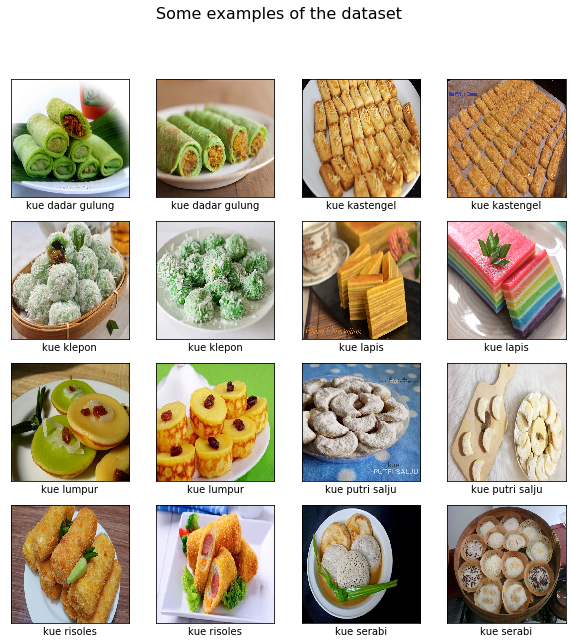

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

labels = ['kue dadar gulung', 'kue kastengel', 'kue klepon', 
          'kue lapis', 'kue lumpur', 'kue putri salju', 'kue risoles', 'kue serabi']

fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of the dataset", fontsize=16)
i = 1
for path in train_dir :
    for j in range(2) :
        img = mpimg.imread(path+os.listdir(path)[j])
        size = min(img.shape[0], img.shape[1])
        img = cv2.resize(img, (size,size))
        
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels[int((i-1)/2)])
        i += 1
plt.show()


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = train_path
train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = validation_path
validation_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))




Found 1525 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


<br><br><br>

# TR InceptionV3

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


In [10]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [14]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 30,
            verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 16 steps
Epoch 1/30
100/100 [==============================] - 92s 915ms/step - loss: 2.3170 - accuracy: 0.4181 - val_loss: 1.1710 - val_accuracy: 0.6500
Epoch 2/30
100/100 [==============================] - 82s 818ms/step - loss: 1.1851 - accuracy: 0.6020 - val_loss: 1.1107 - val_accuracy: 0.6625
Epoch 3/30
100/100 [==============================] - 79s 790ms/step - loss: 1.0632 - accuracy: 0.6372 - val_loss: 0.8934 - val_accuracy: 0.7188
Epoch 4/30
100/100 [==============================] - 88s 879ms/step - loss: 0.9360 - accuracy: 0.6824 - val_loss: 1.1100 - val_accuracy: 0.7063
Epoch 5/30
100/100 [==============================] - 79s 786ms/step - loss: 0.8643 - accuracy: 0.6950 - val_loss: 0.9514 - val_accuracy: 0.7188
Epoch 6/30
100/100 [==============================] - 78s 777ms/step - loss: 0.7850 - accuracy: 0.7327 - val_loss: 0.8696 - val_accuracy: 0.7375
Epoch 7/30
100/100 [=================

In [17]:
tfjs.converters.save_keras_model(model, 'tfjs_model')

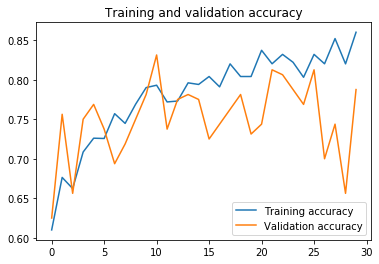

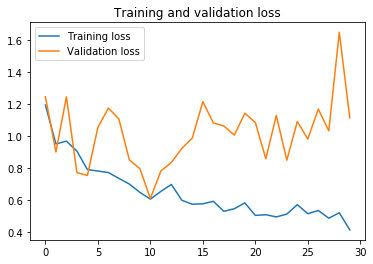

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [21]:
TEST_DIR = test_path
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=10)

Found 158 images belonging to 8 classes.


In [22]:
results = model.evaluate(test_generator)

  ...
    to  
  ['...']
16/16 [==============================] - 8s 529ms/step - loss: 1.0786 - accuracy: 0.8228


<br><br><br>

# TR VGG

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

local_weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


In [29]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [30]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [31]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [32]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 30,
            verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 16 steps
Epoch 1/30
100/100 [==============================] - 145s 1s/step - loss: 2.0434 - accuracy: 0.4452 - val_loss: 1.0213 - val_accuracy: 0.6375
Epoch 2/30
100/100 [==============================] - 162s 2s/step - loss: 1.0617 - accuracy: 0.6312 - val_loss: 0.9827 - val_accuracy: 0.6625
Epoch 3/30
100/100 [==============================] - 146s 1s/step - loss: 0.9501 - accuracy: 0.6412 - val_loss: 1.0108 - val_accuracy: 0.6375
Epoch 4/30
100/100 [==============================] - 142s 1s/step - loss: 0.8429 - accuracy: 0.7045 - val_loss: 0.8698 - val_accuracy: 0.6875
Epoch 5/30
100/100 [==============================] - 142s 1s/step - loss: 0.8813 - accuracy: 0.6894 - val_loss: 0.9086 - val_accuracy: 0.6875
Epoch 6/30
100/100 [==============================] - 141s 1s/step - loss: 0.8073 - accuracy: 0.7226 - val_loss: 0.8979 - val_accuracy: 0.6750
Epoch 7/30
100/100 [=============================

In [33]:
results = model.evaluate(test_generator)

  ...
    to  
  ['...']
16/16 [==============================] - 27s 2s/step - loss: 0.8034 - accuracy: 0.8165


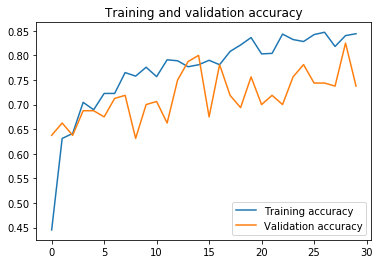

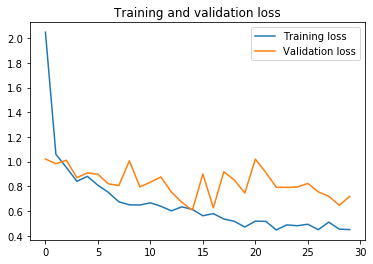

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

<br><br><br>

# TR VGG

In [39]:
from tensorflow.keras.applications.vgg19 import VGG19

local_weights_file = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG19(input_shape = (150, 150, 3), 
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [40]:
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [41]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [42]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [43]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 30,
            verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 16 steps
Epoch 1/30
100/100 [==============================] - 210s 2s/step - loss: 2.1224 - accuracy: 0.4181 - val_loss: 1.4570 - val_accuracy: 0.4750
Epoch 2/30
100/100 [==============================] - 200s 2s/step - loss: 1.2750 - accuracy: 0.5450 - val_loss: 1.0942 - val_accuracy: 0.6250
Epoch 3/30
100/100 [==============================] - 170s 2s/step - loss: 1.0614 - accuracy: 0.6390 - val_loss: 1.1393 - val_accuracy: 0.6438
Epoch 4/30
100/100 [==============================] - 170s 2s/step - loss: 1.0696 - accuracy: 0.6131 - val_loss: 1.0823 - val_accuracy: 0.6062
Epoch 5/30
100/100 [==============================] - 168s 2s/step - loss: 1.0106 - accuracy: 0.6643 - val_loss: 0.9763 - val_accuracy: 0.6500
Epoch 6/30
100/100 [==============================] - 168s 2s/step - loss: 0.9393 - accuracy: 0.6510 - val_loss: 0.9965 - val_accuracy: 0.6625
Epoch 7/30
100/100 [=============================

In [44]:
results = model.evaluate(test_generator)

  ...
    to  
  ['...']
16/16 [==============================] - 22s 1s/step - loss: 0.7060 - accuracy: 0.7468


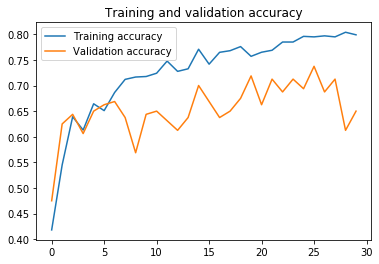

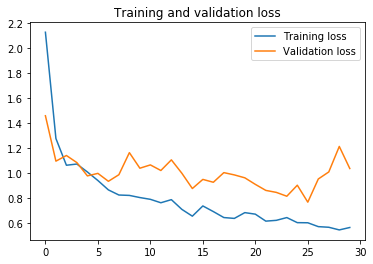

In [45]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [1]:
import tensorflowjs as tfjs

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16

local_weights_file = 'model_inceptionV3.h5'
pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

tfjs.converters.save_keras_model(pre_trained_model, 'n/')

ValueError: You are trying to load a weight file containing 142 layers into a model with 16 layers.